<a href="https://colab.research.google.com/github/nickwan/nwds-stream-notebooks/blob/main/current_season_pybaseball_random_stats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pybaseball

In [ ]:
import pickle
import os
import warnings
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pybaseball

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import log_loss, accuracy_score, mean_squared_error
from sklearn.model_selection import GroupKFold, KFold
from scipy.stats import pearsonr

dt_str = format(datetime.datetime.now(), '%Y%M%d%H%M%S')

In [ ]:
project_dir = 'drive/My Drive/baseball'

In [ ]:
df = pd.read_csv(f"{project_dir}/data/2018_2020_data.csv")
df.shape

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (45) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(1754439, 91)

In [ ]:
in_play = [x for x in df['description'].unique() if 'hit_into_play' in x]
bip = df.loc[df['description'].isin(in_play)]
for event in bip['events'].unique():
  bip[f'is_{event}'] = 0
  bip.loc[bip['events']==event, f'is_{event}'] = 1
bip['park'] = bip['home_team'].astype('category').cat.codes
park_lkup = bip.loc[:, ['home_team','park']].drop_duplicates()
park_lkup.to_csv(f"{project_dir}/data/park_lkup.csv", index=False)
for col in ['if_fielding_alignment', 'of_fielding_alignment']:
  bip[f'{col}_code'] = bip[col].astype('category').cat.codes
bip = bip.merge(bip.loc[:, ['on_3b', 'on_2b', 'on_1b']].fillna(0).astype(bool).astype(int).rename(columns={'on_3b':'is_on_3b', 'on_2b':'is_on_2b', 'on_1b':'is_on_1b'}), left_index=True, right_index=True)
bip['is_top'] = 0
bip.loc[bip['inning_topbot']=='Top', 'is_top'] = 1
bip['bat_left'] = 0
bip.loc[bip['stand']=='L', 'bat_left'] = 1
bip['pit_left'] = 0
bip.loc[bip['p_throws']=='L', 'pit_left'] = 1
bip.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

(302023, 117)

In [ ]:
park_lkup = pd.read_csv(f"{project_dir}/data/park_lkup.csv")
not_in_play = [x for x in df['description'].unique() if 'hit_into_play' not in x]
nbip = df.loc[df['description'].isin(not_in_play)]
for event in nbip['events'].unique():
  nbip[f'is_{event}'] = 0
  nbip.loc[nbip['events']==event, f'is_{event}'] = 1
nbip = nbip.merge(park_lkup)
for col in ['if_fielding_alignment', 'of_fielding_alignment']:
  nbip[f'{col}_code'] = nbip[col].astype('category').cat.codes
nbip = nbip.drop('is_nan', axis=1)
nbip = nbip.merge(nbip.loc[:, ['on_3b', 'on_2b', 'on_1b']].fillna(0).astype(bool).astype(int).rename(columns={'on_3b':'is_on_3b', 'on_2b':'is_on_2b', 'on_1b':'is_on_1b'}), left_index=True, right_index=True)
nbip['is_top'] = 0
nbip.loc[nbip['inning_topbot']=='Top', 'is_top'] = 1
nbip['bat_left'] = 0
nbip.loc[nbip['stand']=='L', 'bat_left'] = 1
nbip['pit_left'] = 0
nbip.loc[nbip['p_throws']=='L', 'pit_left'] = 1
nbip.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


(1452416, 117)

In [ ]:
feats = ['game_year','park', 'inning', 'is_top', 'outs_when_up', 'balls',
         'strikes', 'is_on_3b', 'is_on_2b', 'is_on_1b', 'release_spin_rate',
         'pfx_x', 'pfx_z','plate_x', 'plate_z', 'effective_speed',
         'if_fielding_alignment_code', 'of_fielding_alignment_code',
         'bat_left', 'pit_left']
nbip_models = {}
targets = [x for x in nbip.columns.values if ('is_' in x) & (x not in ['is_on_3b','is_on_2b','is_on_1b','is_top']) & ('pickoff' not in x) & ('caught' not in x) & ('run' not in x)]
for target in targets:
  model_data = nbip.loc[:, feats+[target]].dropna()
  model = RandomForestClassifier()
  model.fit(model_data.loc[:, feats], model_data.loc[:, target])
  nbip_models[target] = model

with open(f'{project_dir}/models/{dt_str}_nbip_batter_models.pickle', 'wb') as handle:
    pickle.dump(nbip_models, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
feats = ['game_year','park', 'inning', 'is_top', 'outs_when_up', 'balls',
         'strikes', 'is_on_3b', 'is_on_2b', 'is_on_1b', 'release_spin_rate',
         'pfx_x', 'pfx_z','plate_x', 'plate_z', 'effective_speed',
         'if_fielding_alignment_code', 'of_fielding_alignment_code',
         'bat_left', 'pit_left', 'launch_speed', 'launch_angle']
bip_models = {}
targets = [x for x in bip.columns.values if ('is_' in x) & (x not in ['is_on_3b','is_on_2b','is_on_1b','is_top'])]
for target in targets:
  model_data = bip.loc[:, feats+[target]].dropna()
  model = RandomForestClassifier()
  model.fit(model_data.loc[:, feats], model_data.loc[:, target])
  bip_models[target] = model

with open(f'{project_dir}/models/{dt_str}_bip_batter_models.pickle', 'wb') as handle:
    pickle.dump(bip_models, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
warnings.filterwarnings('ignore')
targets = [x for x in nbip.columns.values if ('is_' in x) & (x not in ['is_on_3b','is_on_2b','is_on_1b','is_top']) & ('pickoff' not in x) & ('caught' not in x) & ('run' not in x)]
feats = ['game_year','park', 'inning', 'is_top', 'outs_when_up', 'balls',
         'strikes', 'is_on_3b', 'is_on_2b', 'is_on_1b', 'release_spin_rate',
         'pfx_x', 'pfx_z','plate_x', 'plate_z', 'effective_speed',
         'if_fielding_alignment_code', 'of_fielding_alignment_code',
         'bat_left', 'pit_left']
kf = GroupKFold(5)
model_data = nbip.loc[:, feats+targets+['batter', 'game_pk']].dropna()

for target_idx, target in enumerate(targets):
  print(f"modeling {target}...")
  _df_pred = pd.DataFrame()
  for train_idx, test_idx in kf.split(model_data, groups=model_data['batter']):
    train_data = model_data.iloc[train_idx]
    test_data = model_data.iloc[test_idx]
    model = RandomForestClassifier()
    model.fit(train_data.loc[:, feats], train_data.loc[:, target])
    try:
      test_data[f"{target}_rf"] = pd.DataFrame(model.predict_proba(test_data.loc[:, feats]), index=test_data.index)[1]
    except:
      test_data[f"{target}_rf"] = pd.DataFrame(model.predict_proba(test_data.loc[:, feats]), index=test_data.index)[0]
      test_data[f"{target}_rf"] = 1-test_data[f"{target}_rf"]
    _df_pred = _df_pred.append(test_data)
  if target_idx==0:
    df_pred_nbip = _df_pred.copy()
  else:
    df_pred_nbip = df_pred_nbip.merge(_df_pred.loc[:, ['batter',f"{target}_rf"]+feats])
warnings.filterwarnings('default')
df_pred_nbip.to_csv(f'{project_dir}/data/df_pred_nbip.csv', index=False)

modeling is_strikeout...
modeling is_walk...
modeling is_hit_by_pitch...
modeling is_interf_def...
modeling is_other_out...
modeling is_strikeout_double_play...
modeling is_batter_interference...


In [ ]:
warnings.filterwarnings('ignore')
targets = [x for x in bip.columns.values if ('is_' in x) & (x not in ['is_on_3b','is_on_2b','is_on_1b','is_top'])]
feats = ['game_year','park', 'inning', 'is_top', 'outs_when_up', 'balls',
         'strikes', 'is_on_3b', 'is_on_2b', 'is_on_1b', 'release_spin_rate',
         'pfx_x', 'pfx_z','plate_x', 'plate_z', 'effective_speed',
         'if_fielding_alignment_code', 'of_fielding_alignment_code',
         'bat_left', 'pit_left', 'launch_speed', 'launch_angle']
kf = GroupKFold(5)
model_data = bip.loc[:, feats+targets+['batter', 'game_pk']].dropna()

for target_idx, target in enumerate(targets):
  print(f"modeling {target}...")
  _df_pred = pd.DataFrame()
  for train_idx, test_idx in kf.split(model_data, groups=model_data['batter']):
    train_data = model_data.iloc[train_idx]
    test_data = model_data.iloc[test_idx]
    model = RandomForestClassifier()
    model.fit(train_data.loc[:, feats], train_data.loc[:, target])
    try:
      test_data[f"{target}_rf"] = pd.DataFrame(model.predict_proba(test_data.loc[:, feats]), index=test_data.index)[1]
    except:
      test_data[f"{target}_rf"] = pd.DataFrame(model.predict_proba(test_data.loc[:, feats]), index=test_data.index)[0]
      test_data[f"{target}_rf"] = 1-test_data[f"{target}_rf"]
    _df_pred = _df_pred.append(test_data)
  if target_idx==0:
    df_pred_bip = _df_pred.copy()
  else:
    df_pred_bip = df_pred_bip.merge(_df_pred.loc[:, ['batter',f"{target}_rf"]+feats])
warnings.filterwarnings('default')
df_pred_bip.to_csv(f'{project_dir}/data/df_pred_bip.csv', index=False)

modeling is_field_out...
modeling is_double...
modeling is_home_run...
modeling is_single...
modeling is_double_play...
modeling is_force_out...
modeling is_triple...
modeling is_grounded_into_double_play...
modeling is_sac_bunt...
modeling is_sac_fly...
modeling is_fielders_choice_out...
modeling is_field_error...
modeling is_fielders_choice...
modeling is_triple_play...
modeling is_sac_fly_double_play...
modeling is_sac_bunt_double_play...
modeling is_interf_def...


In [ ]:
df_pred_nbip = pd.read_csv(f'{project_dir}/data/df_pred_nbip.csv')
df_pred_bip = pd.read_csv(f'{project_dir}/data/df_pred_bip.csv')
targets = [x for x in nbip.columns.values if ('is_' in x) & (x not in ['is_on_3b','is_on_2b','is_on_1b','is_top']) & ('pickoff' not in x) & ('caught' not in x) & ('run' not in x)]
_bats = df_pred_nbip.loc[:, ['game_year', 'batter']+[targets[0]]].groupby(['game_year', 'batter'], as_index=False).count().rename(columns={targets[0]:'n_nbip'})
bats_nbip = df_pred_nbip.loc[:, ['game_year', 'batter']+targets+[f"{x}_rf" for x in targets]].groupby(['game_year', 'batter'], as_index=False).sum().merge(_bats)
for target in targets:
  bats_nbip[f'{target}_rate'] = bats_nbip[f'{target}'].div(bats_nbip['n_nbip'])
  bats_nbip[f'{target}_xrate'] = bats_nbip[f'{target}_rf'].div(bats_nbip['n_nbip'])

targets = [x for x in bip.columns.values if ('is_' in x) & (x not in ['is_on_3b','is_on_2b','is_on_1b','is_top'])]
_bats = df_pred_bip.loc[:, ['game_year', 'batter']+[targets[0]]].groupby(['game_year', 'batter'], as_index=False).count().rename(columns={targets[0]:'n_bip'})
bats = df_pred_bip.loc[:, ['game_year', 'batter']+targets+[f"{x}_rf" for x in targets]].groupby(['game_year', 'batter'], as_index=False).sum().merge(_bats)
for target in targets:
  bats[f'{target}_rate'] = bats[f'{target}'].div(bats['n_bip'])
  bats[f'{target}_xrate'] = bats[f'{target}_rf'].div(bats['n_bip'])

nbip_rename = {x:f"{x}_nbip" for x in bats.columns.values if (x in bats_nbip.columns.values) and (x not in ['batter', 'game_year'])}
bats = bats.merge(bats_nbip.rename(columns=nbip_rename))
bats.shape

(2352, 100)

In [ ]:
bat_ids = pybaseball.playerid_reverse_lookup(bats['batter'].unique())
bat_ids['full_name'] = bat_ids['name_last'].add(', ').add(bat_ids['name_first'])
fg = pybaseball.fg_batting_data(2018, 2020, qual=1)
fg_war = fg.loc[:, ['Season','IDfg', 'WAR']].groupby(['Season','IDfg'], as_index=False).sum()
_bats = bat_ids.loc[:, ['full_name', 'key_mlbam', 'key_fangraphs']].rename(columns={'key_mlbam':'batter', 'key_fangraphs':'IDfg'}).merge(fg_war).rename(columns={'Season':'game_year'})
bats = bats.merge(_bats)

war_feats = [x for x in bats.columns.values if 'xrate' in x]
feats = ['game_year'] + war_feats
target = 'WAR'
model_data = bats.loc[:, feats+[target]].dropna()
war_model = RandomForestRegressor()
war_model.fit(model_data.loc[:, feats], model_data.loc[:, target])

with open(f'{project_dir}/models/{dt_str}_war_batter_model.pickle', 'wb') as handle:
    pickle.dump(model, handle, protocol=pickle.HIGHEST_PROTOCOL)

Gathering player lookup table. This may take a moment.


In [ ]:
warnings.filterwarnings('ignore')
bat_ids = pybaseball.playerid_reverse_lookup(bats['batter'].unique())
bat_ids['full_name'] = bat_ids['name_last'].add(', ').add(bat_ids['name_first'])
fg = pybaseball.fg_batting_data(2018, 2020, qual=1)
fg_war = fg.loc[:, ['Season','IDfg', 'WAR']].groupby(['Season','IDfg'], as_index=False).sum()
_bats = bat_ids.loc[:, ['full_name', 'key_mlbam', 'key_fangraphs']].rename(columns={'key_mlbam':'batter', 'key_fangraphs':'IDfg'}).merge(fg_war).rename(columns={'Season':'game_year'})
bats = bats.merge(_bats)

war_feats = [x for x in bats.columns.values if 'xrate' in x]
feats = ['game_year'] + war_feats
target = 'WAR'
kf = GroupKFold(10)
df_pred = pd.DataFrame()
for train_idx, test_idx in kf.split(bats, groups=bats['IDfg']):
  train_data = bats.iloc[train_idx]
  test_data = bats.iloc[test_idx]
  model = LinearRegression()
  model.fit(train_data.loc[:, feats], train_data.loc[:, target])
  test_data[f"x{target}"] = pd.Series(model.predict(test_data.loc[:, feats]), index=test_data.index)

  model = RandomForestRegressor()
  model.fit(train_data.loc[:, feats], train_data.loc[:, target])
  test_data[f"x{target}_rf"] = pd.Series(model.predict(test_data.loc[:, feats]), index=test_data.index)
  df_pred = df_pred.append(test_data)
df_pred[f"{target}_diff"] = df_pred[target].sub(df_pred[f"x{target}_rf"])
warnings.filterwarnings('default')
df_pred.to_csv(f'{project_dir}/data/war_preds.csv', index=False)
df_pred.shape


(2275, 106)

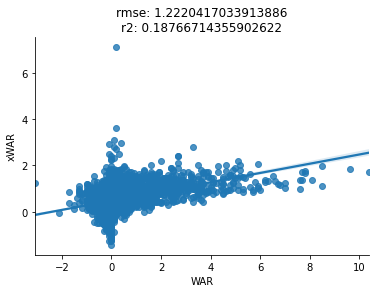

In [ ]:
target = 'WAR'
r2 = pearsonr(df_pred[target], df_pred[f"x{target}"])[0]**2
rmse = mean_squared_error(df_pred[target], df_pred[f"x{target}"])**0.5
sns.regplot(data=df_pred,x=target,y=f'x{target}')
plt.title(f"""rmse: {rmse}\nr2: {r2}""")
sns.despine()
plt.show()

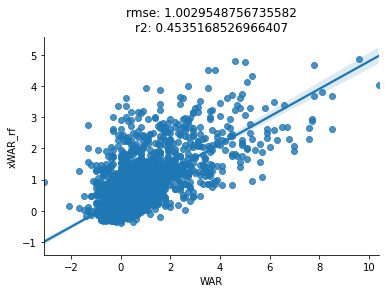

In [ ]:
target = 'WAR'
r2 = pearsonr(df_pred[target], df_pred[f"x{target}_rf"])[0]**2
rmse = mean_squared_error(df_pred[target], df_pred[f"x{target}_rf"])**0.5
sns.regplot(data=df_pred,x=target,y=f'x{target}_rf')
plt.title(f"""rmse: {rmse}\nr2: {r2}""")
sns.despine()
plt.show()

In [ ]:
df_pred.sort_values(f"x{target}_rf",ascending=False).loc[:, ['game_year', 'full_name', target, f"x{target}_rf", f"{target}_diff"]].head(20)

,game_year,full_name,WAR,xWAR_rf,WAR_diff
337,2018.0,"trout, mike",9.6,4.878,4.722
1173,2019.0,"harper, bryce",4.6,4.797,-0.197
424,2018.0,"carpenter, matt",5.0,4.760,0.240
1569,2019.0,"bellinger, cody",7.8,4.687,3.113
113,2018.0,"votto, joey",3.5,4.522,-1.022
1770,2019.0,"álvarez, yordan",3.8,4.505,-0.705
1073,2019.0,"grandal, yasmani",5.3,4.322,0.978
462,2018.0,"judge, aaron",5.1,4.129,0.971
572,2018.0,"betts, mookie",10.4,4.029,6.371
866,2018.0,"ohtani, shohei",2.7,3.997,-1.297


In [ ]:
df_pred.sort_values(f"x{target}_rf",ascending=False).loc[:, ['game_year', 'full_name', target, f"x{target}_rf", f"{target}_diff"]].tail(20)

,game_year,full_name,WAR,xWAR_rf,WAR_diff
986,2019.0,"kemp, matt",-0.8,-0.285,-0.515
1677,2019.0,"mullins, cedric",-0.7,-0.289,-0.411
752,2018.0,"tocci, carlos",-0.5,-0.290,-0.210
624,2018.0,"fedde, erick",-0.1,-0.293,0.193
850,2018.0,"newcomb, sean",-0.3,-0.294,-0.006
1988,2020.0,"ravelo, rangel",-0.1,-0.295,0.195
1550,2019.0,"mejia, erick",0.0,-0.298,0.298
155,2018.0,"hellickson, jeremy",-0.2,-0.310,0.110
2220,2020.0,"tucker, cole",-0.5,-0.310,-0.190
1710,2019.0,"rodgers, brendan",-0.6,-0.318,-0.282


In [ ]:
df_pred.sort_values('WAR_diff',ascending=False).loc[:, ['game_year', 'full_name', target, f"x{target}_rf", f"{target}_diff"]].head(20)

,game_year,full_name,WAR,xWAR_rf,WAR_diff
572,2018.0,"betts, mookie",10.4,4.029,6.371
1438,2019.0,"bregman, alex",8.5,2.625,5.875
1149,2019.0,"semien, marcus",7.6,2.294,5.306
1147,2019.0,"rendon, anthony",7.0,1.926,5.074
646,2018.0,"bregman, alex",7.6,2.656,4.944
1413,2019.0,"marte, ketel",7.0,2.074,4.926
487,2018.0,"yelich, christian",7.7,2.874,4.826
1165,2019.0,"trout, mike",8.5,3.693,4.807
535,2018.0,"lindor, francisco",7.7,2.936,4.764
337,2018.0,"trout, mike",9.6,4.878,4.722


In [ ]:
df_pred.sort_values('WAR_diff',ascending=False).loc[:, ['game_year', 'full_name', target, f"x{target}_rf", f"{target}_diff"]].tail(20)

,game_year,full_name,WAR,xWAR_rf,WAR_diff
53,2018.0,"wieters, matt",0.4,2.924,-2.524
1116,2019.0,"cron, c. j.",0.3,2.873,-2.573
794,2018.0,"mckinney, billy",0.0,2.610,-2.610
1665,2019.0,"diaz, isan",-1.2,1.478,-2.678
918,2019.0,"walker, neil",0.4,3.164,-2.764
1091,2019.0,"forsythe, logan",0.2,3.009,-2.809
1456,2019.0,"guzman, ronald",-0.3,2.548,-2.848
1031,2019.0,"davis, khris",-0.9,1.965,-2.865
179,2018.0,"solarte, yangervis",-1.3,1.570,-2.870
1213,2019.0,"lamb, jake",0.0,2.912,-2.912


In [ ]:
# save for validation stats
# model_type = 'rf'
# acc = accuracy_score(df_pred[target], round(df_pred[f"{target}_{model_type}"], 0))
# loss = log_loss(df_pred[target], df_pred[f"{target}_{model_type}"])
# sns.boxplot(data=df_pred, x=target, y=f"{target}_{model_type}")
# plt.title(f"acc: {acc}\nloss: {loss}")
# sns.despine()
# plt.show()

In [ ]:
df_cur = pybaseball.statcast(start_dt='2021-03-20', end_dt=format(datetime.datetime.now(), "%Y-%m-%d"))
df_cur.shape

This is a large query, it may take a moment to complete


/usr/local/lib/python3.7/dist-packages/pybaseball/statcast.py:50: UserWarning: 
That's a nice request you got there. It'd be a shame if something were to happen to it.
We strongly recommend that you enable caching before running this. It's as simple as `pybaseball.cache.enable()`.
Since the Statcast requests can take a *really* long time to run, if something were to happen, like: a disconnect;
gremlins; computer repair by associates of Rudy Giuliani; electromagnetic interference from metal trash cans; etc.;
you could lose a lot of progress. Enabling caching will allow you to immediately recover all the successful
subqueries if that happens.
  warnings.warn(_OVERSIZE_WARNING)
100%|██████████| 98/98 [01:29<00:00,  1.10it/s]


(321726, 92)

In [ ]:
park_lkup = pd.read_csv(f"{project_dir}/data/park_lkup.csv")

in_play = [x for x in df_cur['description'].unique() if 'hit_into_play' in x]
bip = df_cur.loc[df['description'].isin(in_play)]
for event in bip['events'].unique():
  bip[f'is_{event}'] = 0
  bip.loc[bip['events']==event, f'is_{event}'] = 1
bip = bip.merge(park_lkup)
for col in ['if_fielding_alignment', 'of_fielding_alignment']:
  bip[f'{col}_code'] = bip[col].astype('category').cat.codes
bip = bip.merge(bip.loc[:, ['on_3b', 'on_2b', 'on_1b']].fillna(0).astype(bool).astype(int).rename(columns={'on_3b':'is_on_3b', 'on_2b':'is_on_2b', 'on_1b':'is_on_1b'}), left_index=True, right_index=True)
bip['is_top'] = 0
bip.loc[bip['inning_topbot']=='Top', 'is_top'] = 1
bip['bat_left'] = 0
bip.loc[bip['stand']=='L', 'bat_left'] = 1
bip['pit_left'] = 0
bip.loc[bip['p_throws']=='L', 'pit_left'] = 1
print(bip.shape)


not_in_play = [x for x in df_cur['description'].unique() if 'hit_into_play' not in x]
nbip = df_cur.loc[df_cur['description'].isin(not_in_play)]
for event in nbip['events'].unique():
  nbip[f'is_{event}'] = 0
  nbip.loc[nbip['events']==event, f'is_{event}'] = 1
nbip = nbip.merge(park_lkup)
for col in ['if_fielding_alignment', 'of_fielding_alignment']:
  nbip[f'{col}_code'] = nbip[col].astype('category').cat.codes
nbip = nbip.drop('is_nan', axis=1)
nbip = nbip.merge(nbip.loc[:, ['on_3b', 'on_2b', 'on_1b']].fillna(0).astype(bool).astype(int).rename(columns={'on_3b':'is_on_3b', 'on_2b':'is_on_2b', 'on_1b':'is_on_1b'}), left_index=True, right_index=True)
nbip['is_top'] = 0
nbip.loc[nbip['inning_topbot']=='Top', 'is_top'] = 1
nbip['bat_left'] = 0
nbip.loc[nbip['stand']=='L', 'bat_left'] = 1
nbip['pit_left'] = 0
nbip.loc[nbip['p_throws']=='L', 'pit_left'] = 1
print(nbip.shape)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


(35463, 123)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(267495, 118)


In [ ]:
warnings.filterwarnings('ignore')
targets = list(nbip_models.keys())
nan_cols = [a for a in targets if a not in [x for x in nbip.columns.values if x in targets] ]
for col in nan_cols:
  nbip[col] = 0
feats = ['game_year','park', 'inning', 'is_top', 'outs_when_up', 'balls',
         'strikes', 'is_on_3b', 'is_on_2b', 'is_on_1b', 'release_spin_rate',
         'pfx_x', 'pfx_z','plate_x', 'plate_z', 'effective_speed',
         'if_fielding_alignment_code', 'of_fielding_alignment_code',
         'bat_left', 'pit_left']
cur_df_pred_nbip = nbip.loc[:, feats+targets+['batter', 'game_pk']].dropna()

for target_idx, target in enumerate(targets):
  print(f"predicting {target}...")
  model = nbip_models[target]
  try:
    cur_df_pred_nbip[f"{target}_rf"] = pd.DataFrame(model.predict_proba(cur_df_pred_nbip.loc[:, feats]), index=cur_df_pred_nbip.index)[1]
  except:
    cur_df_pred_nbip[f"{target}_rf"] = pd.DataFrame(model.predict_proba(cur_df_pred_nbip.loc[:, feats]), index=cur_df_pred_nbip.index)[0]
    cur_df_pred_nbip[f"{target}_rf"] = 1-cur_df_pred_nbip[f"{target}_rf"]

warnings.filterwarnings('default')
cur_df_pred_nbip.to_csv(f'{project_dir}/data/cur_df_pred_nbip.csv', index=False)


predicting is_strikeout...
predicting is_walk...
predicting is_hit_by_pitch...
predicting is_interf_def...
predicting is_other_out...
predicting is_strikeout_double_play...
predicting is_batter_interference...


In [ ]:
warnings.filterwarnings('ignore')
targets = list(bip_models.keys())
nan_cols = [a for a in targets if a not in [x for x in bip.columns.values if x in targets]]
for col in nan_cols:
  bip[col] = 0
feats = ['game_year','park', 'inning', 'is_top', 'outs_when_up', 'balls',
         'strikes', 'is_on_3b', 'is_on_2b', 'is_on_1b', 'release_spin_rate',
         'pfx_x', 'pfx_z','plate_x', 'plate_z', 'effective_speed',
         'if_fielding_alignment_code', 'of_fielding_alignment_code',
         'bat_left', 'pit_left', 'launch_speed', 'launch_angle']

cur_df_pred_bip = bip.loc[:, feats+targets+['batter', 'game_pk']].dropna()

for target_idx, target in enumerate(targets):
  print(f"predicting {target}...")
  model = bip_models[target]
  try:
    cur_df_pred_bip[f"{target}_rf"] = pd.DataFrame(model.predict_proba(cur_df_pred_bip.loc[:, feats]), index=cur_df_pred_bip.index)[1]
  except:
    cur_df_pred_bip[f"{target}_rf"] = pd.DataFrame(model.predict_proba(cur_df_pred_bip.loc[:, feats]), index=cur_df_pred_bip.index)[0]
    cur_df_pred_bip[f"{target}_rf"] = 1-cur_df_pred_bip[f"{target}_rf"]

warnings.filterwarnings('default')
cur_df_pred_bip.to_csv(f'{project_dir}/data/cur_df_pred_bip.csv', index=False)

predicting is_field_out...
predicting is_double...
predicting is_home_run...
predicting is_single...
predicting is_double_play...
predicting is_force_out...
predicting is_triple...
predicting is_grounded_into_double_play...
predicting is_sac_bunt...
predicting is_sac_fly...
predicting is_fielders_choice_out...
predicting is_field_error...
predicting is_fielders_choice...
predicting is_triple_play...
predicting is_sac_fly_double_play...
predicting is_sac_bunt_double_play...
predicting is_interf_def...


In [ ]:
# load models with this
# with open(f'{project_dir}/models/{dt_str}_batter_models.pickle', 'rb') as handle:
#     bip_models = pickle.load(handle)

In [ ]:
cur_df_pred_nbip = pd.read_csv(f'{project_dir}/data/cur_df_pred_nbip.csv')
cur_df_pred_bip = pd.read_csv(f'{project_dir}/data/cur_df_pred_bip.csv')
targets = list(nbip_models.keys())
_bats = cur_df_pred_nbip.loc[:, ['game_year', 'batter']+[targets[0]]].groupby(['game_year', 'batter'], as_index=False).count().rename(columns={targets[0]:'n_nbip'})
bats_nbip = cur_df_pred_nbip.loc[:, ['game_year', 'batter']+targets+[f"{x}_rf" for x in targets]].groupby(['game_year', 'batter'], as_index=False).sum().merge(_bats)
for target in targets:
  bats_nbip[f'{target}_rate'] = bats_nbip[f'{target}'].div(bats_nbip['n_nbip'])
  bats_nbip[f'{target}_xrate'] = bats_nbip[f'{target}_rf'].div(bats_nbip['n_nbip'])

targets = list(bip_models.keys())
_bats = cur_df_pred_bip.loc[:, ['game_year', 'batter']+[targets[0]]].groupby(['game_year', 'batter'], as_index=False).count().rename(columns={targets[0]:'n_bip'})
bats = cur_df_pred_bip.loc[:, ['game_year', 'batter']+targets+[f"{x}_rf" for x in targets]].groupby(['game_year', 'batter'], as_index=False).sum().merge(_bats)
for target in targets:
  bats[f'{target}_rate'] = bats[f'{target}'].div(bats['n_bip'])
  bats[f'{target}_xrate'] = bats[f'{target}_rf'].div(bats['n_bip'])

nbip_rename = {x:f"{x}_nbip" for x in bats.columns.values if (x in bats_nbip.columns.values) and (x not in ['batter', 'game_year'])}
bats = bats.merge(bats_nbip.rename(columns=nbip_rename))
bats.shape

(656, 100)

In [ ]:
warnings.filterwarnings('ignore')
bat_ids = pybaseball.playerid_reverse_lookup(bats['batter'].unique())
bat_ids['full_name'] = bat_ids['name_last'].add(', ').add(bat_ids['name_first'])
fg = pybaseball.fg_batting_data(2021, qual=1)
fg_war = fg.loc[:, ['Season','IDfg', 'WAR']].groupby(['Season','IDfg'], as_index=False).sum()
_bats = bat_ids.loc[:, ['full_name', 'key_mlbam', 'key_fangraphs']].rename(columns={'key_mlbam':'batter', 'key_fangraphs':'IDfg'}).merge(fg_war).rename(columns={'Season':'game_year'})
bats = bats.merge(_bats)
war_feats = [x for x in bats.columns.values if 'xrate' in x]
feats = ['game_year'] + war_feats
target = 'WAR'
bats[f"x{target}_rf"] = pd.Series(war_model.predict(bats.loc[:, feats]), index=bats.index)
bats[f"{target}_diff"] = bats[target].sub(bats[f"x{target}_rf"])
warnings.filterwarnings('default')
bats.to_csv(f'{project_dir}/data/cur_war_preds.csv', index=False)
bats.shape


(532, 105)

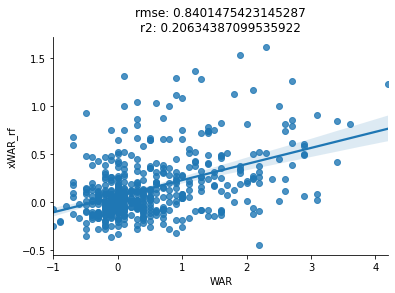

In [ ]:
target = 'WAR'
r2 = pearsonr(bats[target], bats[f"x{target}_rf"])[0]**2
rmse = mean_squared_error(bats[target], bats[f"x{target}_rf"])**0.5
sns.regplot(data=bats,x=target,y=f'x{target}_rf')
plt.title(f"""rmse: {rmse}\nr2: {r2}""")
sns.despine()
plt.show()

In [ ]:
bats.sort_values(f"x{target}_rf",ascending=False).loc[:, ['game_year', 'full_name', target, f"x{target}_rf", f"{target}_diff"]].head(20)

,game_year,full_name,WAR,xWAR_rf,WAR_diff
138,2021,"trout, mike",2.3,1.610,0.690
201,2021,"judge, aaron",1.9,1.533,0.367
222,2021,"polanco, jorge",1.2,1.365,-0.165
245,2021,"odor, rougned",0.1,1.309,-1.209
77,2021,"donaldson, josh",0.9,1.295,-0.395
78,2021,"freeman, freddie",1.3,1.280,0.020
443,2021,"devers, rafael",2.7,1.257,1.443
508,2021,"guerrero, vladimir",4.2,1.233,2.967
202,2021,"machado, manny",2.1,1.169,0.931
6,2021,"cruz, nelson",1.8,1.123,0.677


In [ ]:
bats.sort_values(f"x{target}_rf",ascending=False).loc[:, ['game_year', 'full_name', target, f"x{target}_rf", f"{target}_diff"]].tail(20)

,game_year,full_name,WAR,xWAR_rf,WAR_diff
330,2021,"swanson, dansby",0.7,-0.224,0.924
268,2021,"bell, josh",0.1,-0.228,0.328
500,2021,"moore, dylan",0.3,-0.241,0.541
359,2021,"senzatela, antonio",-0.2,-0.242,0.042
223,2021,"sano, miguel",-0.2,-0.243,0.043
64,2021,"anderson, chase",-0.1,-0.245,0.145
200,2021,"jones, jacoby",-1.0,-0.249,-0.751
80,2021,"heyward, jason",0.0,-0.252,0.252
302,2021,"pillar, kevin",0.5,-0.257,0.757
423,2021,"adames, willy",1.0,-0.261,1.261


In [ ]:
bats.sort_values(f"{target}_diff",ascending=False).loc[:, ['game_year', 'full_name', target, f"x{target}_rf", f"{target}_diff"]].head(20)

,game_year,full_name,WAR,xWAR_rf,WAR_diff
507,2021,"tatis, fernando",3.1,0.027,3.073
191,2021,"castellanos, nick",3.1,0.080,3.020
220,2021,"bogaerts, xander",3.4,0.419,2.981
508,2021,"guerrero, vladimir",4.2,1.233,2.967
296,2021,"turner, trea",2.9,0.066,2.834
481,2021,"acuna, ronald",3.6,0.814,2.786
48,2021,"gurriel, yuli",2.2,-0.444,2.644
333,2021,"correa, carlos",3.4,0.846,2.554
189,2021,"canha, mark",2.5,0.015,2.485
526,2021,"smith, will",2.6,0.116,2.484


In [ ]:
bats.sort_values(f"{target}_diff",ascending=False).loc[:, ['game_year', 'full_name', target, f"x{target}_rf", f"{target}_diff"]].tail(20)

,game_year,full_name,WAR,xWAR_rf,WAR_diff
1,2021,"cabrera, miguel",-0.9,-0.204,-0.696
527,2021,"hiura, keston",-0.9,-0.197,-0.703
431,2021,"jansen, danny",-0.3,0.426,-0.726
122,2021,"miller, brad",0.3,1.044,-0.744
200,2021,"jones, jacoby",-1.0,-0.249,-0.751
361,2021,"reyes, victor",-0.8,-0.044,-0.756
424,2021,"gutierrez, kelvin",-0.7,0.056,-0.756
378,2021,"frazier, clint",-0.7,0.091,-0.791
84,2021,"moreland, mitch",-0.4,0.391,-0.791
151,2021,"suarez, eugenio",-0.1,0.753,-0.853


In [ ]:
bats_hr = bats.loc[:, ['batter','full_name', 'n_bip', 'is_home_run', 'is_home_run_rf']].groupby(['batter','full_name'], as_index=False).sum().sort_values(['is_home_run_rf', 'n_bip'], ascending=[False, True])
bats_hr['hr_diff'] = bats_hr['is_home_run'].sub(bats_hr['is_home_run_rf'])

In [ ]:
bats_hr.head(20)

,batter,full_name,n_bip,is_home_run,is_home_run_rf,hr_diff
479,660271,"ohtani, shohei",28,4,4.29,-2.900000e-01
78,518692,"freeman, freddie",49,2,4.01,-2.010000e+00
155,570482,"urshela, gio",51,2,3.87,-1.870000e+00
201,592450,"judge, aaron",31,4,3.77,2.300000e-01
227,594807,"duvall, adam",32,3,3.71,-7.100000e-01
36,467793,"santana, carlos",49,2,3.58,-1.580000e+00
304,608070,"ramirez, jose",50,3,3.58,-5.800000e-01
508,665489,"guerrero, vladimir",28,3,3.45,-4.500000e-01
443,646240,"devers, rafael",46,2,3.44,-1.440000e+00
461,656555,"hoskins, rhys",47,2,3.32,-1.320000e+00


In [ ]:
bats_hr.tail(20)

,batter,full_name,n_bip,is_home_run,is_home_run_rf,hr_diff
425,642736,"leyba, domingo",2,0,0.0,0.0
445,647351,"toro, abraham",2,0,0.0,0.0
464,656605,"keller, mitch",2,0,0.0,0.0
472,657277,"webb, logan",2,0,0.0,0.0
47,489119,"miley, wade",3,0,0.0,0.0
110,543101,"desclafani, anthony",3,0,0.0,0.0
317,608597,"guzman, ronald",3,0,0.0,0.0
341,621450,"bolt, skye",3,0,0.0,0.0
382,640470,"alzolay, adbert",3,0,0.0,0.0
460,656546,"hoffman, jeff",3,0,0.0,0.0


In [ ]:
bats_hr.sort_values('hr_diff', ascending=False).head(20)

,batter,full_name,n_bip,is_home_run,is_home_run_rf,hr_diff
296,607208,"turner, trea",46,4,2.41,1.59
406,641857,"mcmahon, ryan",44,4,2.66,1.34
333,621043,"correa, carlos",46,3,1.68,1.32
108,543063,"crawford, brandon",29,3,1.89,1.11
471,657077,"verdugo, alex",48,3,2.01,0.99
368,624415,"biggio, cavan",24,2,1.02,0.98
481,660670,"acuna, ronald",30,3,2.22,0.78
289,606299,"peraza, jose",21,2,1.24,0.76
245,596059,"odor, rougned",25,3,2.26,0.74
102,542364,"ortega, rafael",3,1,0.26,0.74


In [ ]:
bats_hr.sort_values('hr_diff', ascending=False).tail(20)

,batter,full_name,n_bip,is_home_run,is_home_run_rf,hr_diff
135,545341,"grichuk, randal",43,1,2.41,-1.41
172,571980,"naquin, tyler",43,1,2.43,-1.43
443,646240,"devers, rafael",46,2,3.44,-1.44
72,516770,"castro, starlin",43,0,1.45,-1.45
528,669720,"hays, austin",20,0,1.46,-1.46
10,446334,"longoria, evan",19,0,1.48,-1.48
112,543228,"gomes, yan",24,0,1.49,-1.49
530,670541,"álvarez, yordan",38,1,2.51,-1.51
184,573262,"yastrzemski, mike",36,0,1.52,-1.52
48,493329,"gurriel, yuli",54,0,1.54,-1.54


In [ ]:
parks = bip.loc[:, ['home_team', 'park']].drop_duplicates()
park_factors = df_pred.loc[:, ['park', 'is_hr', 'is_hr_rf', 'hroe_rf', 'is_hr_pf']].groupby('park', as_index=False).sum()
park_factors = parks.merge(park_factors)

KeyError: ignored

In [ ]:
def plot_park_factors(x, y, data):
  order = data.sort_values(x)[y].unique()
  sns.barplot(data=data, y=y, x=x, order = order)
  plt.axvline(0, c='k', ls=':')
  plt.gcf().set_size_inches(plt.gcf().get_size_inches()[0], 6)
  plt.xlabel('')
  sns.despine()
  plt.show()

In [ ]:
y='home_team'
for x in ['is_hr', 'is_hr_rf', 'hroe_rf', 'is_hr_pf']:
  plot_park_factors(x, y, data=park_factors)

In [ ]:
_batter_hr = df_pred.loc[:, ['batter', 'hroe_rf']].groupby('batter', as_index=False).count().rename(columns={'hroe_rf':'n_bip'})
batter_hr = df_pred.loc[:, ['batter', 'is_hr', 'hroe_rf']].groupby('batter', as_index=False).sum().merge(_batter_hr)
batter_ids = pybaseball.playerid_reverse_lookup(batter_hr['batter'].unique())
batter_ids['full_name'] = batter_ids['name_last'].add(', ').add(batter_ids['name_first'])
id_join = batter_ids.loc[:, ['key_mlbam', 'full_name']].rename(columns={'key_mlbam':'batter'})
batter_hr = id_join.merge(batter_hr)

In [ ]:
sns.kdeplot(batter_hr['n_bip'])
batter_hr['n_bip'].describe()

In [ ]:
batter_hr.loc[batter_hr['n_bip']>=batter_hr['n_bip'].quantile(.67)].sort_values('hroe_rf').head(20)